In [3]:
%matplotlib notebook
import pandas as pd
import numpy as np
import glob
import json
from pprint import pprint
from collections import OrderedDict
from math import sin, cos, radians

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
raw = []
# datafile = 'data/data_2019-05-11-190455.json'
datafile = "/Users/allen/Downloads/data/data_2019-05-12-025705.json"
with open(datafile, "r") as f:
    for row in f:
        item = json.loads(row)
        raw.append(item)

print("{} samples".format(len(raw)))
pprint(raw[0])

417 samples
{'distance': {'cm': 72.47, 'inches': 28.53},
 'euler_angles': {'heading': 250.3125, 'pitch': -8.5, 'roll': 0.75},
 'imu_calibration': {'accelerometer': 3,
                     'gyroscope': 3,
                     'magnetometer': 3,
                     'system': 0},
 'linear_acceleration': {'x': -0.06, 'y': -0.01, 'z': 0.11},
 'quaternion': {'w': 0.57440185546875,
                'x': 0.04852294921875,
                'y': 0.0567626953125,
                'z': 0.81512451171875},
 'time': {'scale': 'microsecond', 'start': 1557644225669871}}


**NOTE** that `linear_acceleration` is in `meters/second^2`

In [5]:
def transform(instance):
    obj = {
        "time": instance["time"]["start"],
    }
    obj.update(instance["euler_angles"])
    obj.update(instance["distance"])
    return obj

data = [transform(ii) for ii in raw]
pprint(data[0])

{'cm': 72.47,
 'heading': 250.3125,
 'inches': 28.53,
 'pitch': -8.5,
 'roll': 0.75,
 'time': 1557644225669871}


In [6]:
df = pd.DataFrame(data)
df.head()

,cm,heading,inches,pitch,roll,time
0,72.47,250.3125,28.53,-8.5000,0.7500,1557644225669871
1,72.38,250.2500,28.50,-8.5000,0.7500,1557644225736985
2,72.30,250.3125,28.46,-8.5000,0.7500,1557644225806495
3,72.51,250.2500,28.55,-8.5000,0.6875,1557644225874058
4,71.45,250.2500,28.13,-8.5625,0.6250,1557644225939461


In [7]:
distance = 124.45
heading = 277.0000
pitch = -24.3125

hypotenuse = distance

print("pitch: {}".format(pitch))
print("pitch (abs): {}".format(abs(pitch)))
print("radians(abs(pitch)): {}".format(radians(abs(pitch))))
print()

if pitch < 0:
    pitch = 360 + pitch

opposite = hypotenuse * sin(radians(abs(pitch)))
adjacent = hypotenuse * cos(radians(abs(pitch)))

print(f"y ({pitch} degrees / {radians(pitch)} radians))")
print(f"opposite: {opposite}")
print(f"adjacent: {adjacent}")
print(f"hypotenuse: {hypotenuse}")


# X

opposite = hypotenuse * sin(radians(heading))
adjacent = hypotenuse * cos(radians(heading))

print(f"\nx ({heading} degrees / {radians(heading)} radians)")
print(f"opposite: {opposite}")
print(f"adjacent: {adjacent}")
print(f"hypotenuse: {hypotenuse}")

pitch: -24.3125
pitch (abs): 24.3125
radians(abs(pitch)): 0.4243331743911214

y (335.6875 degrees / 5.858852132788465 radians))
opposite: -51.23770601762444
adjacent: 113.41296214300857
hypotenuse: 124.45

x (277.0 degrees / 4.834562028024293 radians)
opposite: -123.52236857176253
adjacent: 15.166639786770629
hypotenuse: 124.45


In [19]:
df2 = df.copy()
# fix pitch to degrees
df2["z"] = df2["pitch"].apply(lambda ii: ii if ii > 0 else 360 + ii)

# calc opposite from pitch and hypotenuse
df2["z_opp"] = np.sin(np.radians(df2["z"])) * df2["cm"]
df2["z_adj"] = np.cos(np.radians(df2["z"])) * df2["cm"]
df2.drop("z", axis=1, inplace=True)



# calc opposite from pitch and hypotenuse
df2["heading_opp"] = np.sin(np.radians(df2["heading"])) * df2["cm"]
df2["heading_adj"] = np.cos(np.radians(df2["heading"])) * df2["cm"]

df2["x"] = df2["heading_opp"]
df2["y"] = df2["heading_adj"]
df2["z"] = df2["z_opp"]


df2.head()

,cm,heading,inches,pitch,roll,time,z_opp,z_adj,heading_opp,heading_adj,x,y,z
0,72.47,250.3125,28.53,-8.5000,0.7500,1557644225669871,-10.711748,71.673980,-68.233698,-24.414408,-68.233698,-24.414408,-10.711748
1,72.38,250.2500,28.50,-8.5000,0.7500,1557644225736985,-10.698445,71.584968,-68.122320,-24.458412,-68.122320,-24.458412,-10.698445
2,72.30,250.3125,28.46,-8.5000,0.7500,1557644225806495,-10.686620,71.505847,-68.073636,-24.357136,-68.073636,-24.357136,-10.686620
3,72.51,250.2500,28.55,-8.5000,0.6875,1557644225874058,-10.717660,71.713540,-68.244673,-24.502341,-68.244673,-24.502341,-10.717660
4,71.45,250.2500,28.13,-8.5625,0.6250,1557644225939461,-10.638060,70.653621,-67.247026,-24.144150,-67.247026,-24.144150,-10.638060


# Try Plotting This

In [20]:
df2[["x","y","z"]].describe()

,x,y,z
count,417.000000,417.000000,417.000000
mean,-193.504744,-68.809240,-17.670042
std,320.362716,188.098243,41.849944
min,-1509.886576,-970.844558,-170.572620
25%,-174.810847,-35.266896,-26.209221
50%,-73.245354,-25.474186,-10.713226
75%,-68.975827,-17.220700,-7.458280
max,-64.246627,44.172610,192.944839


In [21]:
# remove outlierss
df2 = df2[df2["x"] > -120]

<IPython.core.display.Javascript object>


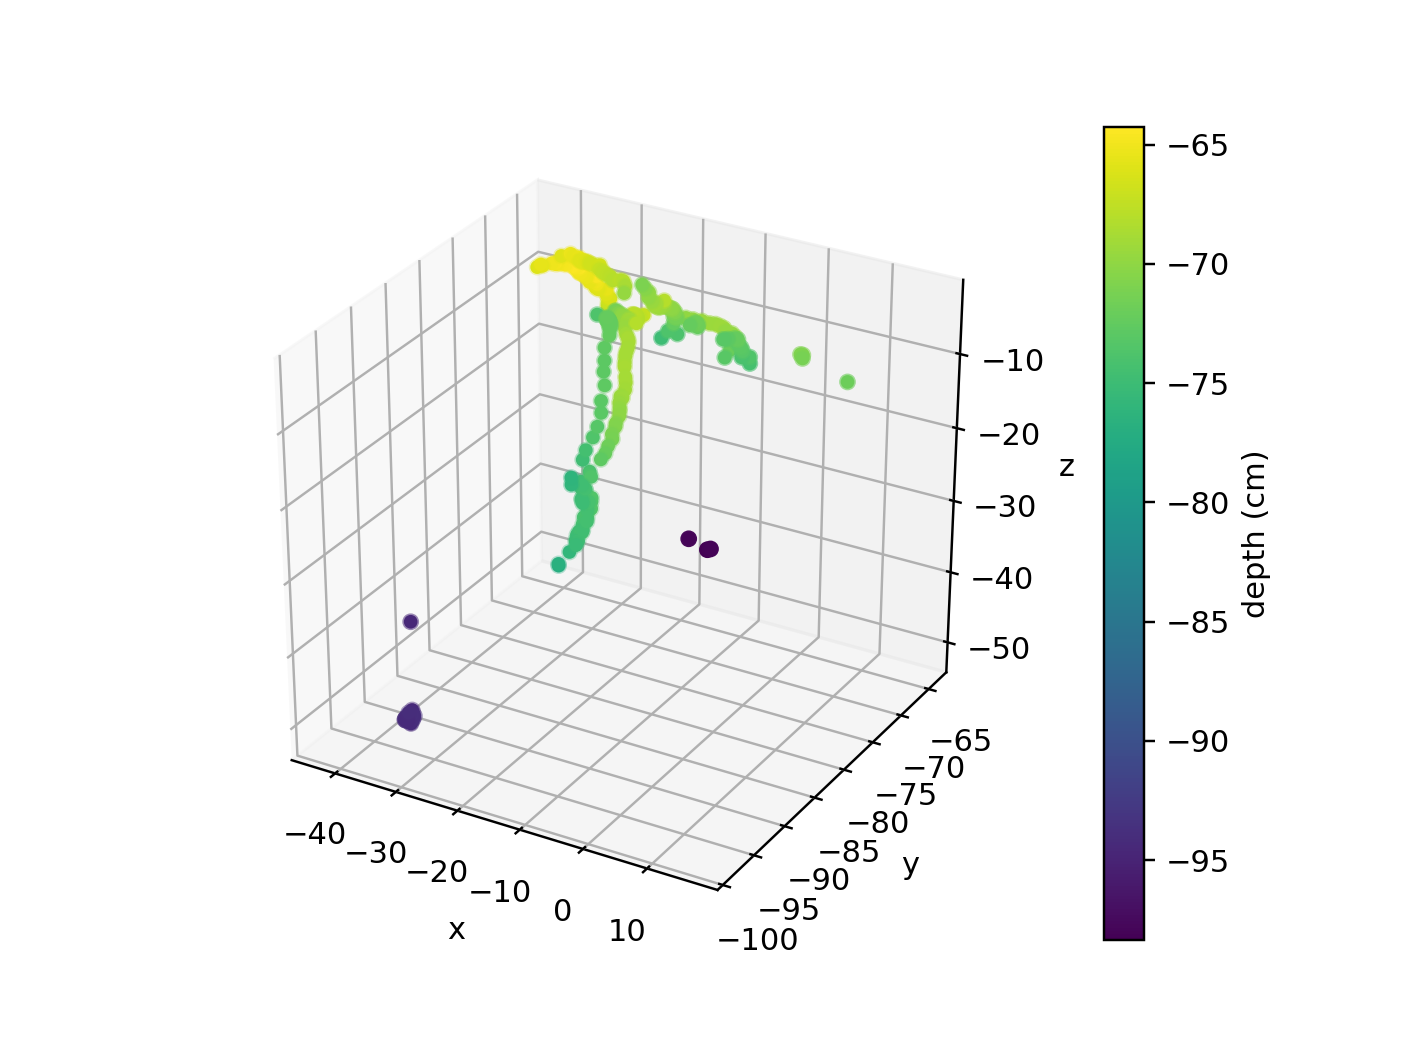

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pnt3d = ax.scatter(df2["y"], df2["x"], df2["z"], c=df2["x"])

# pnt3d=ax.scatter(x,y,z,c=z)

# create colorbar
cbar = plt.colorbar(pnt3d)
cbar.set_label("depth (cm)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()